In [1]:
import midynet
import midynet.util.display as display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
import numpy as np


plot = midynet.metrics.Statistics.plot

display.setup_dir("./")

## Loading data from experiment

In [2]:


exp = {}
bit_ratio = np.log(2)
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure2/exact-{dynamics}/")
    if (path_to_data / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path_to_data / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})

xlabel = r"Number of time steps"
titles = {"ising": r"\textbf{Ising Glauber}", "sis": r"\textbf{SIS}", "cowan": r"\textbf{Cowan}"}
couplingLabels = {"ising": r"J\langle k \rangle", "sis": r"\frac{\alpha \langle k \rangle}{\beta}", "cowan": r"\nu\langle k \rangle"}

## Figure 2 revisited

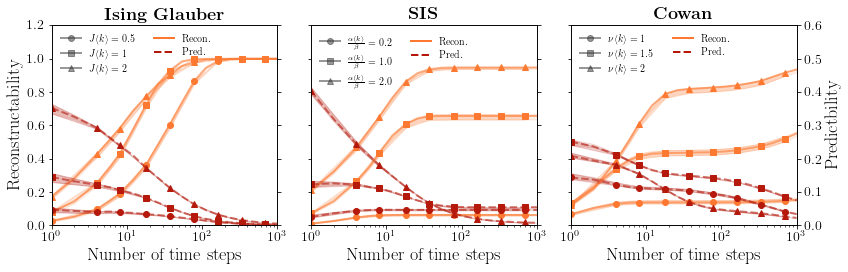

In [232]:
# fig = plt.figure(constrained_layout=True)
# gs = fig.add_gridspec(1, 3)
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax = {dynamics: ax[i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics)}


recon_color = display.dark_colors["orange"]
pred_color = display.dark_colors["red"]

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    x = exp[dynamics].config.dynamics.num_steps
    coupling = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        coupling = [c for c in coupling]
    alpha = np.linspace(0, 1, len(coupling) + 2)[2:] ** 1.5
    recon = mi[dynamics] / hg[dynamics]
    pred = mi[dynamics] / hx[dynamics]
    for c_index, (c, a) in reversed(list(enumerate(zip(coupling, alpha)))):
        
        y = recon if len(coupling) == 1 else recon[:, c_index]
        plot(
            ax[dynamics], 
            x, y,
            color=recon_color,
            alpha=0.6,
            linestyle="-",
            marker="None",
        )
        y = recon if len(coupling) == 1 else recon[::2, c_index]
        plot(
            ax[dynamics], 
            x[::2], y,
            color=recon_color,
            alpha=1,
            linestyle="None",
            marker=markers[c_index],
            markersize=6,
        )
        
        
        y = pred if len(coupling) == 1 else pred[:, c_index]
        plot(
            axx[dynamics], 
            x, y,
            color=pred_color,
            alpha=0.6,
            linestyle="--",
            marker="None",
        )
        y = pred if len(coupling) == 1 else pred[::2, c_index]
        plot(
            axx[dynamics], 
            x[::2], y,
            color=pred_color,
            alpha=1,
            linestyle="None",
            marker=markers[c_index],
            markersize=6,
        )
    
    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=18)
    if dynamics_id == len(all_dynamics)-1:
        axx[dynamics].set_ylabel(r"Predictbility", fontsize=18)
    else:
        axx[dynamics].axes.xaxis.set_ticklabels([])
        axx[dynamics].axes.yaxis.set_ticklabels([])
    ax[dynamics].set_xlabel(xlabel, fontsize=18)
    ax[dynamics].tick_params(axis='both', labelsize=14)
    ax[dynamics].set_xlim([1, 1000])
    ax[dynamics].set_ylim([0., 1.2])
    ax[dynamics].set_xscale("log")
    ax[dynamics].set_title(titles[dynamics], fontsize=18)

#     ax[dynamics][1].axhline(1, linestyle="--", color=display.dark_colors["grey"], marker="None", linewidth=2)
    axx[dynamics].set_xlabel(xlabel, fontsize=18)
    axx[dynamics].tick_params(axis='both', labelsize=14)
    axx[dynamics].set_xlim([1, 1000])
    axx[dynamics].set_xscale("log")
    axx[dynamics].set_ylim([0, 0.6])
    
    handles = [
        Line2D([0], [0], marker=markers[i], linestyle="-", color=display.dark_colors["grey"], label=rf"${couplingLabels[dynamics]} = {c}$", alpha=0.5)
        for i, c in enumerate(coupling)
    ]
    handles += [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Recon.", alpha=1, linewidth=2)]
    handles += [Line2D([0], [0], marker="None", linestyle="--", color=pred_color, label=r"Pred.", alpha=1, linewidth=2)]
    ax[dynamics].legend(handles=handles, loc="upper left", fontsize=10, ncol=2, frameon=False)
    display.label_plot(ax[dynamics])


fig.tight_layout()
fig.savefig(f"./svg/p1-figure2rev.svg")
fig.savefig(f"./pdf/p1-figure2rev.pdf")
fig.savefig(f"./png/p1-figure2rev.png")

In [132]:
E = 5
N = 5
avgk = 2 * E / N
beta = 0.5
alpha = 1 / avgk

In [153]:
markers = display.markers


In [134]:
from scipy.optimize import bisect
def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def wc_thresholds(a=4, b=0.5, m=1):
    def h(x, c):
        return -b * x + (1 - x) * sigmoid(a * (c * x - m))

    def f1_to_solve(c):
        q = c * a
        x = (1 + np.sqrt(1 - 4 * (1 + b)/ q)) / (2 * (1 + b))
        return h(x, c)

    def f2_to_solve(c):
        q = c * a
        x = (1 - np.sqrt(1 - 4 * (1 + b)/ q)) / (2 * (1 + b))
        return h(x, c)
    c1, c2 = None, None
    if np.sign(f1_to_solve(4 * (1 + b) / a)) != np.sign(f1_to_solve(100)):
        c1 = bisect(f1_to_solve, a=4 * (1 + b) / a, b=100)
    if np.sign(f2_to_solve(4 * (1 + b) / a)) != np.sign(f2_to_solve(100)):
        c2 = bisect(f2_to_solve, a=4 * (1 + b) / a, b=100)
    return c1, c2

In [141]:
t, _ = wc_thresholds(a=exp["cowan"].config.dynamics.a, b=exp["cowan"].config.dynamics.eta, m=exp["cowan"].config.dynamics.mu)


In [178]:
Line2D



NameError: name 'Line2D' is not defined